Visualizing the learned representation.

In [ ]:
# install once on machine
! pip install colorcet


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import colorsys
import colorcet as cc

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestCentroid

import matplotlib.pyplot as plt

HOME_DIR = str(pathlib.Path(os.path.abspath('')).parent) + "/"  # project path
sys.path.append(HOME_DIR)

from OT_deep_score_src.data_processing_utilities import build_sequence_features
from OT_deep_score_src.general_utilities import Padding_type

FILES_DIR = HOME_DIR + "files/"
DATASETS_PATH = FILES_DIR + "datasets/"
flat_encoding = False

In [39]:
def ensemble_predict(modles, x):
    return np.mean([model.predict(x, verbose=0) for model in modles], axis=0)

In [40]:
def embedding_t_sne_map(embedded_vectors_2d, test_dataset_df_list, t_sne_random_state, file_name, dots_sizes=(0.2, 0.2), plot_rna_centroids=True,
                                    plot_dna_centroids=True, plot_colors_palette=False,
                                    title='t-SNE representation by mismatches, DNA bulges, and RNA bulges'):
    # Create a scatter plot
    alphas = [1, 1, 1]
    acc_index = 0

    fold_i_size = len(test_dataset_df_list[0])
    embedded_vectors_2d_i = embedded_vectors_2d[acc_index: acc_index + fold_i_size]
    acc_index += fold_i_size

    if plot_colors_palette:
        _, axs = plt.subplots(3, figsize=(8, 10), gridspec_kw={'height_ratios': [20, 1, 1]})
    else: 
        _, ax = plt.subplots()
        axs = [ax]
    # Mismatches
    x_tsne= embedded_vectors_2d_i[:, 0]
    y_tsne = embedded_vectors_2d_i[:, 1]
    axs[0].scatter(x_tsne, y_tsne, s=dots_sizes[0] ,alpha=alphas[0], color="orange")

    # bulges
    bulge_test_dataset_df = test_dataset_df_list[1]
    fold_i_size = len(test_dataset_df_list[1])
    embedded_vectors_2d_i = embedded_vectors_2d[acc_index: acc_index + fold_i_size]
    acc_index += fold_i_size

    # DNA bulges
    colors = []
    for color_i in range(0, 256, 256//22):
        colors.append(cc.CET_L16[color_i]) # CET_CBTL2 
    # colors = [colorsys.hls_to_rgb(i*(1/23), 0.9, 1) for i in range(23)]
    for bulge_loc in range(1, 23):
        bulge_loc_mask = (bulge_test_dataset_df["Align.sgRNA"].str.find("-") == bulge_loc)
        x_tsne = embedded_vectors_2d_i[:, 0][bulge_loc_mask]
        y_tsne = embedded_vectors_2d_i[:, 1][bulge_loc_mask]
        axs[0].scatter(x_tsne, y_tsne, s=dots_sizes[1] ,alpha=alphas[1], color=colors[bulge_loc - 1]) #, label="{}".format(bulge_loc))
        
        if plot_dna_centroids:
            # Calculate the centroid
            if len(x_tsne) == 0:
                print("skipping", bulge_loc)
            else:
                x_center = np.array([[x_i, y_i] for (x_i, y_i) in zip(x_tsne, y_tsne)]+ [[5,5]])
                y_center = np.array([1 for _ in range(len(x_tsne))] + [2])
                clf = NearestCentroid()
                clf.fit(x_center, y_center)
                centroid = clf.centroids_[0]
                centroid_x, centroid_y = centroid

                # Plot the centroid position with cluster number
                plt.gca().annotate(f'{bulge_loc + 1}', (centroid_x, centroid_y), color=colorsys.hls_to_rgb(0, 1, 0.5),
                            fontsize='12', ha='center', va='center', weight='bold')
            
    # RNA bulges
    colors = []
    for color_i in range(0, 256, 256//23):
        colors.append(cc.CET_L19[color_i]) # glasbey_light  
    # colors = [colorsys.hls_to_rgb(i*(1/23), 0.35, 1) for i in range(23)]
    for bulge_loc in range(23):
        bulge_loc_mask = (bulge_test_dataset_df["Align.off-target"].str.find("-") == bulge_loc)
        x_tsne = embedded_vectors_2d_i[:, 0][bulge_loc_mask]
        y_tsne = embedded_vectors_2d_i[:, 1][bulge_loc_mask]
        axs[0].scatter(x_tsne, y_tsne, s=dots_sizes[1] ,alpha=alphas[2], color=colors[bulge_loc]) #, label="{}".format(bulge_loc))
        
        if plot_rna_centroids:
            # Calculate the centroid
            if len(x_tsne) == 0:
                print("skipping", bulge_loc)
            else:
                x_center = np.array([[x_i, y_i] for (x_i, y_i) in zip(x_tsne, y_tsne)]+ [[5,5]])
                y_center = np.array([1 for _ in range(len(x_tsne))] + [2])
                clf = NearestCentroid()
                clf.fit(x_center, y_center)
                centroid = clf.centroids_[0]
                centroid_x, centroid_y = centroid

                # Plot the centroid position with cluster number
                axs[0].annotate(f'{bulge_loc + 1}', (centroid_x, centroid_y), color='black',
                            fontsize='12', ha='center', va='center', weight='bold')

    axs[0].set_xlabel('t-SNE dimension 1')
    axs[0].set_ylabel('t-SNE dimension 2')
    axs[0].set_title(title)


    # Background color
    axs[0].patch.set_facecolor('darkgrey')
    axs[0].patch.set_alpha(0.35)

    # Mismatches legend 
    axs[0].plot([], [], 'o', color="orange", label='No bulge', markersize=5)
    lgnd_1 = axs[0].legend()
    lgnd_1.get_frame().set_facecolor('darkgrey')
    if plot_rna_centroids or plot_dna_centroids:
        # Bulge legend
        ax_twin = axs[0].twinx()
        ax_twin.set_yticks([])
        if plot_rna_centroids:
            ax_twin.plot(np.NaN, np.NaN, 's', color="black", label='RNA bulge', markersize=25, marker="$1..23$")
        if plot_dna_centroids:
            ax_twin.plot(np.NaN, np.NaN, 's', color="white", label='DNA bulge', markersize=25, marker="$2..23$")
        lgnd_2 = ax_twin.legend(loc=2, title='Bulge centroids')
        lgnd_2.get_frame().set_facecolor('darkgrey')

    if plot_colors_palette:
        # RNA colors
        ax_rna_colors = axs[1]
        for i, color_i in enumerate(range(0, 256, 256//23)):
            ax_rna_colors.fill_between([i, i+1], 0, 1, color=cc.CET_L19  [color_i])
        
        ax_rna_colors.set_xlim(0, 23)
        ax_rna_colors.set_ylim(0, 1)
        # Hide major tick labels
        ax_rna_colors.set_xticklabels('')
        # Customize minor tick labels
        ax_rna_colors.set_xticks(np.arange(0, 23, 5) + 0.5, minor=True)
        ax_rna_colors.set_xticklabels(np.arange(1, 24, 5), minor=True)

        plt.setp(ax_rna_colors.get_xticklabels(), visible=True)
        plt.setp(ax_rna_colors.get_yticklabels(), visible=False)
        ax_rna_colors.tick_params(axis='both', which='both', length=0)
        ax_rna_colors.spines['top'].set_visible(False)
        ax_rna_colors.spines['right'].set_visible(False)
        ax_rna_colors.spines['bottom'].set_visible(False)
        ax_rna_colors.spines['left'].set_visible(False)
        # ax_rna_colors.set_title("RNA bulge position")
        ax_rna_colors.set_ylabel("RNA bulge\nposition", size=8, rotation=0, labelpad=50, loc="bottom")
        
        # DNA colors
        ax_dna_colors = axs[2]
        for i, color_i in enumerate(range(0, 256, 256//22)):
            ax_dna_colors.fill_between([i, i+1], 0, 1, color=cc.CET_L16  [color_i])

        ax_dna_colors.set_xlim(0, 22)
        ax_dna_colors.set_ylim(0, 1)

        # Hide major tick labels
        ax_dna_colors.set_xticklabels('')
        # Customize minor tick labels
        ax_dna_colors.set_xticks(np.arange(0, 22, 5) + 0.5, minor=True)
        ax_dna_colors.set_xticklabels(np.arange(2, 24, 5), minor=True)

        plt.setp(ax_dna_colors.get_xticklabels(), visible=True)
        plt.setp(ax_dna_colors.get_yticklabels(), visible=False)
        ax_dna_colors.tick_params(axis='both', which='both', length=0)
        ax_dna_colors.spines['top'].set_visible(False)
        ax_dna_colors.spines['right'].set_visible(False)
        ax_dna_colors.spines['bottom'].set_visible(False)
        ax_dna_colors.spines['left'].set_visible(False)
        # ax_dna_colors.set_title("DNA bulge position")
        ax_dna_colors.set_ylabel("DNA bulge\nposition", size=8, rotation=0, labelpad=50, loc="bottom")

    # Display the plot
    plt.tight_layout()
    plt.savefig("plots/{}_{}.png".format(file_name, t_sne_random_state), dpi=1000, bbox_inches='tight') # transparent=True
    plt.show()

In [41]:
# Load the model from a file
models = [load_model(FILES_DIR + 'bulges/1_folds/5_revision_ensemble_{}_exclude_RHAMPseq_continue_from_change_seq/read_ts_0/cleavage_models/aligned/FullGUIDEseq/classification/c_2/ln_x_plus_one_trans/model_fold_0.h5'.format(i)) for i in range(5)]

embedding_models = [tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[1].output) for model in models]

2024-03-17 11:38:45.030951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 11:38:45.032440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 11:38:45.033417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [42]:
# load generated OTS files names
# Note: due to the size of the generated tables,
# you need to run the script that generates the OTS for the embedding from OT_deep_score_src/generate_synthetic_ots_for_embedding.py
folder_path = DATASETS_PATH + "generated_off_targets_for_embedding/"

# Get all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# load sgRNAs sequences
sg_rnas = list(pd.read_csv(DATASETS_PATH + "CHANGEseq_sgRNAs_list.csv", header=None).squeeze("columns"))

**Embedding analysis with subtracting on-target embedding**

In [43]:
def t_sne(t_sne_random_state=1):
    sg_rnas_embeddings_list_no_bulges = []
    sg_rnas_embeddings_list_bulges = []
    sampled_dfs_list_no_bulges = []
    sampled_dfs_list_bulges = []

    rng = np.random.default_rng(seed=0)
    sg_rna_indices = rng.choice(110, size=20, replace=False)

    sg_rna_samples_sizes = [1794, 1794*2] # [1000, 2000]
    for sg_rna_index in sg_rna_indices:
        target_dataset_df = pd.read_csv(folder_path + files[sg_rna_index])
        target_dataset_df = target_dataset_df.rename({"Alignment Bulge Size": "Align.#Bulges", "sgRNA": "Align.sgRNA", "off-target": "Align.off-target"}, axis=1)
        test_dataset_df_list = [target_dataset_df[(target_dataset_df["Align.#Bulges"] == i) & (target_dataset_df["Alignment distance"] <= 3)].sample(sg_rna_samples_sizes[i], random_state=3) for i in range(2)]

        test_dataset_features = [build_sequence_features(
            test_dataset_df.copy(), bulges=True, aligned=True,
            padding_type=Padding_type.GAP, flat_encoding=flat_encoding, verbose=0) for test_dataset_df in test_dataset_df_list]

        x = np.concatenate((test_dataset_features))
        x = np.argmax(x, axis=2)
        embedding_vectors = ensemble_predict(embedding_models, x)  # embedding_models[0].predict(x, verbose=0)

        test_dataset_features = build_sequence_features(
            target_dataset_df.iloc[:1].copy(), bulges=True, aligned=True,
            padding_type=Padding_type.GAP, flat_encoding=flat_encoding, verbose=0)

        x = np.argmax(test_dataset_features, axis=2)
        base_embedding_vector =  ensemble_predict(embedding_models, x)  # embedding_models[0].predict(x, verbose=0)
        embedding_vectors = embedding_vectors - base_embedding_vector

        sg_rnas_embeddings_list_no_bulges.append(embedding_vectors[:sg_rna_samples_sizes[0]])
        sg_rnas_embeddings_list_bulges.append(embedding_vectors[sg_rna_samples_sizes[0]:])
        sampled_dfs_list_no_bulges.append(test_dataset_df_list[0])
        sampled_dfs_list_bulges.append(test_dataset_df_list[1])

    embedding_vectors = np.concatenate([np.concatenate(sg_rnas_embeddings_list_no_bulges), np.concatenate(sg_rnas_embeddings_list_bulges)])
    test_dataset_df_list = [pd.concat(sampled_dfs_list_no_bulges), pd.concat(sampled_dfs_list_bulges)]
    tsne = TSNE(n_components=2, random_state=t_sne_random_state, n_jobs=-1)
    embedding_vectors = embedding_vectors.reshape(embedding_vectors.shape[0], embedding_vectors.shape[1]*embedding_vectors.shape[2])
    embedded_vectors_2d = tsne.fit_transform(embedding_vectors)

    embedding_t_sne_map(embedded_vectors_2d, test_dataset_df_list, t_sne_random_state=t_sne_random_state,
                    file_name="t_sne_1_20_sgRNAs_sample_1000_up_3_edit_distance_GRU_Emb_class_ensemble_mean_option_1", dots_sizes=(0.5, 0.25),
                    plot_dna_centroids=False, plot_colors_palette=True, title='t-SNE representation by mismatches, DNA bulges, and RNA bulges - embedding')

skipping 20


/tmp/ipykernel_9616/2420919453.py:105: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax_twin.plot(np.NaN, np.NaN, 's', color="black", label='RNA bulge', markersize=25, marker="$1..23$")


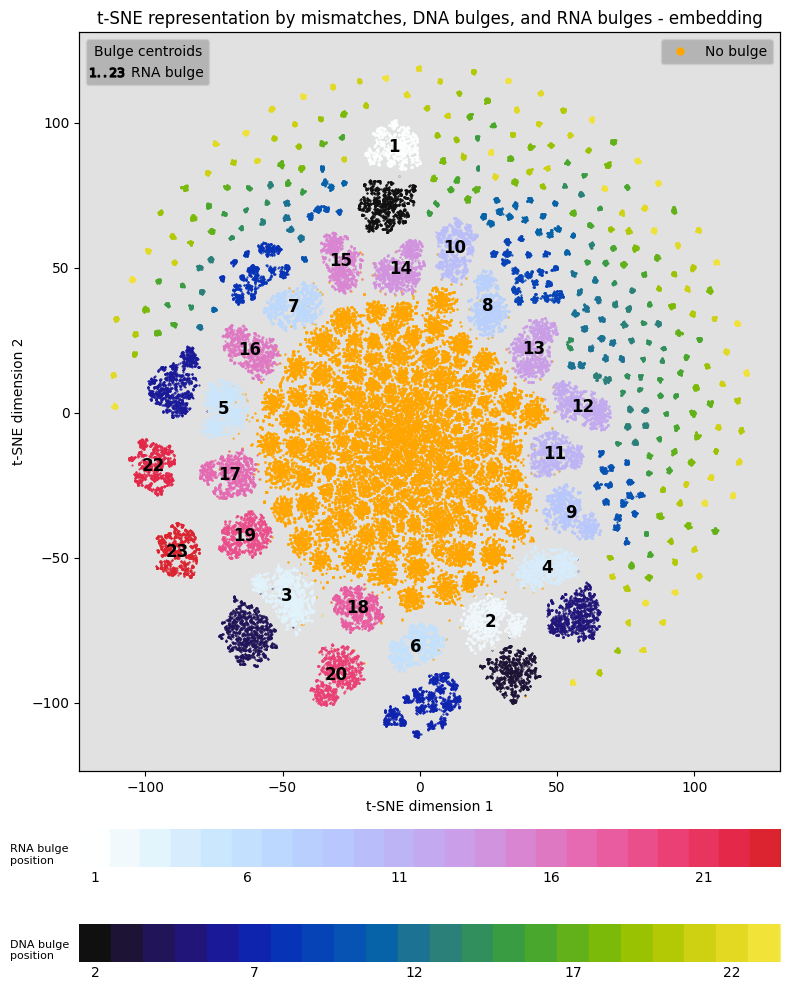

In [36]:
t_sne(t_sne_random_state=19)

**Embedding analysis without subtracting on-target embedding**

In [44]:
sg_rnas_embeddings_list_no_bulges = []
sg_rnas_embeddings_list_bulges = []
sampled_dfs_list_no_bulges = []
sampled_dfs_list_bulges = []

rng = np.random.default_rng(seed=0)
sg_rna_indices = rng.choice(110, size=20, replace=False)

sg_rna_samples_sizes = [1794, 1794*2] # [1000, 2000]
for sg_rna_index in sg_rna_indices:
    target_dataset_df = pd.read_csv(folder_path + files[sg_rna_index])
    target_dataset_df = target_dataset_df.rename({"Alignment Bulge Size": "Align.#Bulges", "sgRNA": "Align.sgRNA", "off-target": "Align.off-target"}, axis=1)
    test_dataset_df_list = [target_dataset_df[(target_dataset_df["Align.#Bulges"] == i) & (target_dataset_df["Alignment distance"] <= 3)].sample(sg_rna_samples_sizes[i], random_state=3) for i in range(2)]

    test_dataset_features = [build_sequence_features(
        test_dataset_df.copy(), bulges=True, aligned=True,
        padding_type=Padding_type.GAP, flat_encoding=flat_encoding, verbose=0) for test_dataset_df in test_dataset_df_list]

    x = np.concatenate((test_dataset_features))
    x = np.argmax(x, axis=2)
    embedding_vectors = ensemble_predict(embedding_models, x)  # embedding_models[0].predict(x, verbose=0)


    sg_rnas_embeddings_list_no_bulges.append(embedding_vectors[:sg_rna_samples_sizes[0]])
    sg_rnas_embeddings_list_bulges.append(embedding_vectors[sg_rna_samples_sizes[0]:])
    sampled_dfs_list_no_bulges.append(test_dataset_df_list[0])
    sampled_dfs_list_bulges.append(test_dataset_df_list[1])

In [45]:
embedding_vectors = np.concatenate([np.concatenate(sg_rnas_embeddings_list_no_bulges), np.concatenate(sg_rnas_embeddings_list_bulges)])
test_dataset_df_list = [pd.concat(sampled_dfs_list_no_bulges), pd.concat(sampled_dfs_list_bulges)]
tsne = TSNE(n_components=2, random_state=19, n_jobs=-1)
embedding_vectors = embedding_vectors.reshape(embedding_vectors.shape[0], embedding_vectors.shape[1]*embedding_vectors.shape[2])
embedded_vectors_2d = tsne.fit_transform(embedding_vectors)

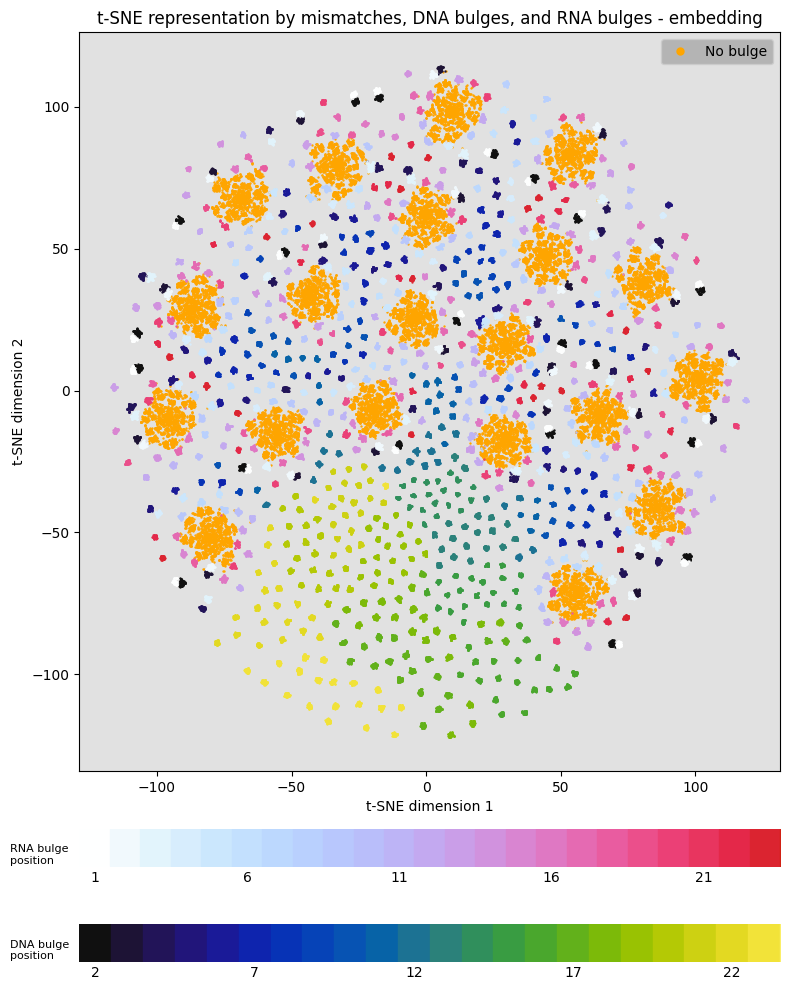

In [46]:
embedding_t_sne_map(embedded_vectors_2d, test_dataset_df_list, t_sne_random_state=1,
                                file_name="t_sne_1_20_sgRNAs_sample_1000_up_3_edit_distance_GRU_Emb_class_ensemble_mean_without_sub_base", dots_sizes=(0.5, 0.5),
                                plot_dna_centroids=False, plot_rna_centroids=False, plot_colors_palette=True,
                                title='t-SNE representation by mismatches, DNA bulges, and RNA bulges - embedding')

**t-SNE with One-hot encdoings**

In [47]:
sg_rnas_embeddings_list_no_bulges = []
sg_rnas_embeddings_list_bulges = []
sampled_dfs_list_no_bulges = []
sampled_dfs_list_bulges = []

rng = np.random.default_rng(seed=0)
sg_rna_indices = rng.choice(110, size=20, replace=False)

sg_rna_samples_sizes = [1794, 1794*2] # [1000, 2000]
for sg_rna_index in sg_rna_indices:
    target_dataset_df = pd.read_csv(folder_path + files[sg_rna_index])
    target_dataset_df = target_dataset_df.rename({"Alignment Bulge Size": "Align.#Bulges", "sgRNA": "Align.sgRNA", "off-target": "Align.off-target"}, axis=1)
    test_dataset_df_list = [target_dataset_df[(target_dataset_df["Align.#Bulges"] == i) & (target_dataset_df["Alignment distance"] <= 3)].sample(sg_rna_samples_sizes[i], random_state=3) for i in range(2)]

    test_dataset_features = [build_sequence_features(
        test_dataset_df.copy(), bulges=True, aligned=True,
        padding_type=Padding_type.GAP, flat_encoding=flat_encoding, verbose=0) for test_dataset_df in test_dataset_df_list]

    x = np.concatenate((test_dataset_features))
    embedding_vectors = x

    test_dataset_features = build_sequence_features(
        target_dataset_df.iloc[:1].copy(), bulges=True, aligned=True,
        padding_type=Padding_type.GAP, flat_encoding=flat_encoding, verbose=0)

    base_embedding_vector =  test_dataset_features
    embedding_vectors = embedding_vectors - base_embedding_vector

    sg_rnas_embeddings_list_no_bulges.append(embedding_vectors[:sg_rna_samples_sizes[0]])
    sg_rnas_embeddings_list_bulges.append(embedding_vectors[sg_rna_samples_sizes[0]:])
    sampled_dfs_list_no_bulges.append(test_dataset_df_list[0])
    sampled_dfs_list_bulges.append(test_dataset_df_list[1])

In [48]:
embedding_vectors = np.concatenate([np.concatenate(sg_rnas_embeddings_list_no_bulges), np.concatenate(sg_rnas_embeddings_list_bulges)])
test_dataset_df_list = [pd.concat(sampled_dfs_list_no_bulges), pd.concat(sampled_dfs_list_bulges)]
tsne = TSNE(n_components=2, random_state=19, n_jobs=-1)
embedding_vectors = embedding_vectors.reshape(embedding_vectors.shape[0], embedding_vectors.shape[1]*embedding_vectors.shape[2])
embedded_vectors_2d = tsne.fit_transform(embedding_vectors)

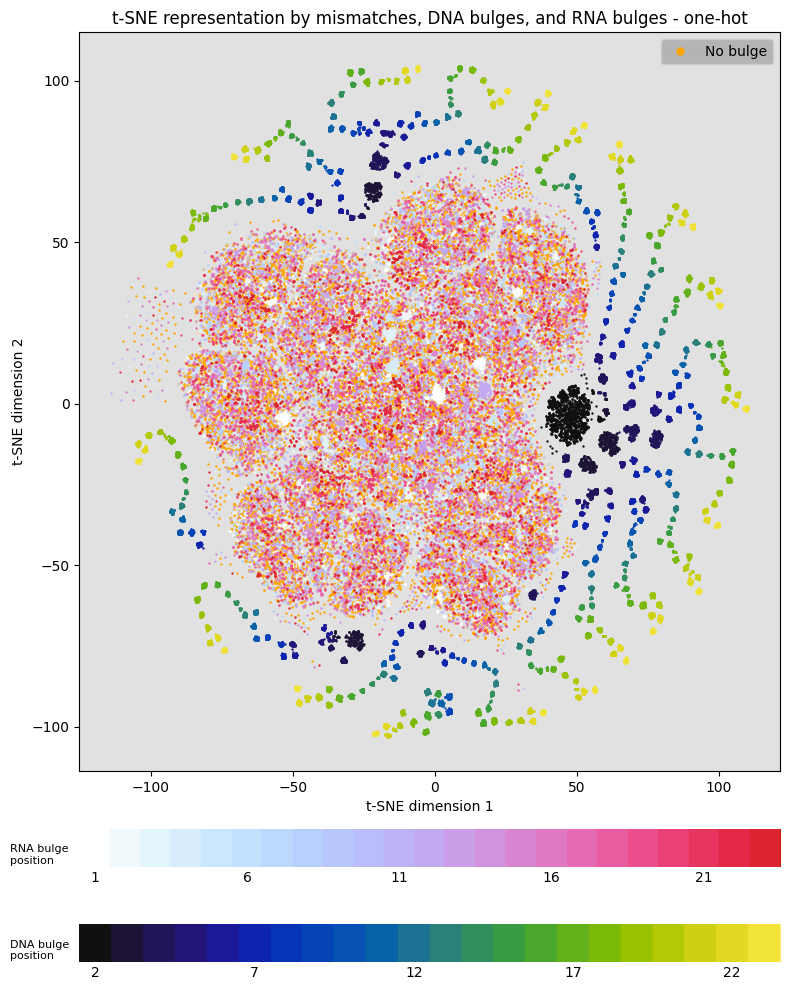

In [49]:
embedding_t_sne_map(embedded_vectors_2d, test_dataset_df_list, t_sne_random_state=1,
                                file_name="t_sne_1_20_sgRNAs_sample_1000_up_3_edit_distance_GRU_Emb_class_one_hot", dots_sizes=(0.5, 0.5),
                                plot_dna_centroids=False, plot_rna_centroids=False, plot_colors_palette=True,
                                title='t-SNE representation by mismatches, DNA bulges, and RNA bulges - one-hot')